In [62]:
!pip install git+https://github.com/baidu/AdvBox.git 

  Cloning https://github.com/baidu/AdvBox.git to /tmp/pip-req-build-8rnbn0mx
  Running command git clone -q https://github.com/baidu/AdvBox.git /tmp/pip-req-build-8rnbn0mx


In [63]:
!pip install -r requirements.txt

  Using cached absl-py-0.4.1.tar.gz (88 kB)
  Using cached astor-0.7.1-py2.py3-none-any.whl (27 kB)
  Using cached backports.functools_lru_cache-1.5-py2.py3-none-any.whl (7.0 kB)
  Using cached backports.weakref-1.0.post1-py2.py3-none-any.whl (5.2 kB)
  Using cached certifi-2018.8.24-py2.py3-none-any.whl (147 kB)
  Using cached enum34-1.1.6-py3-none-any.whl (12 kB)
  Using cached funcsigs-1.0.2-py2.py3-none-any.whl (17 kB)
ERROR: Could not find a version that satisfies the requirement futures==3.2.0 (from versions: 0.2.python3, 0.1, 0.2, 1.0, 2.0, 2.1, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 3.0.0, 3.0.1, 3.0.2, 3.0.3, 3.0.4, 3.0.5, 3.1.0, 3.1.1)
ERROR: No matching distribution found for futures==3.2.0


In [64]:
import logging
logging.basicConfig(level=logging.INFO,format="%(filename)s[line:%(lineno)d] %(levelname)s %(message)s")
logger=logging.getLogger(__name__)

import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
from adversarialbox.adversary import Adversary
from adversarialbox.attacks.deepfool import DeepFoolAttack
from adversarialbox.attacks.gradient_method import FGSMT
from adversarialbox.models.pytorch import PytorchModel
import numpy as np
import cv2
import tensorflow
import matplotlib.pyplot as plt
from past.utils import old_div
#from tools import show_images_diff

In [65]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [66]:
import sys
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-8tnxudda
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-8tnxudda


In [67]:
def show_images_diff(original_img, original_label, adversarial_img, adversarial_label):
    plt.figure()

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img

    l0 = np.where(difference != 0)[0].shape[0]
    l2 = np.linalg.norm(difference)
    # print(difference)
    print("l0={} l2={}".format(l0, l2))

    # (-1,1)  -> (0,1)
    difference = old_div(difference, abs(difference).max()) / 2.0 + 0.5

    plt.imshow(difference, cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [68]:
result = True
image_path = tensorflow.keras.utils.get_file('Panda', origin= 'https://pbs.twimg.com/profile_images/829274786362699776/a1ttXfVG.jpg')

In [69]:
# Define what device we are using
logging.info("CUDA Available: {}".format(torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# bgr -> rgb   
orig = cv2.imread(image_path)[..., ::-1]

orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std

 
#[224,224,3]->[3,224,224]
img = img.transpose(2, 0, 1)

img = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0)).cpu().numpy()


# Initialize the network

model = models.resnet50(pretrained=True).to(device).eval()

#print(model)


for param in model.parameters():
    param.requires_grad = False

# advbox demo
m = PytorchModel(
    model, None,(-3, 3),
    channel_axis=1)
attack = FGSMT(m)

#epsilons
attack_config = {"epsilons": 0.001, "epsilon_steps": 1, "steps": 100}

inputs=img
labels = None

print(inputs.shape)

adversary = Adversary(inputs, labels)

tlabel = 538
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)


if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]

else:
    result = False
    print('attack failed')


print("fgsm attack done")

<ipython-input-69-40acf132d619>[line:2] INFO CUDA Available: False
pytorch.py[line:53] INFO Finish PytorchModel init


cpu
(1, 3, 224, 224)


base.py[line:75] INFO adversary:
         original_label: 388
         target_label: 538
         is_targeted_attack: True
gradient_method.py[line:74] INFO epsilons=0.001,epsilons_max=0.5,steps=100,epsilon_steps=1
gradient_method.py[line:121] INFO step=1, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=12.619359016418457
gradient_method.py[line:121] INFO step=2, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=11.131569862365723
gradient_method.py[line:121] INFO step=3, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=9.85976505279541
gradient_method.py[line:121] INFO step=4, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=8.749063491821289
gradient_method.py[line:121] INFO step=5, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=7.8893914222717285
gradient_method.py[line:121] INFO step=6, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=7.3138957023620605
gradient_method.py[line:121] INFO step=7, epsilon = 0.00100, pre_label = 388, adv

attack success, adversarial_label=538
fgsm attack done


l0=84669 l2=58266.829663196884


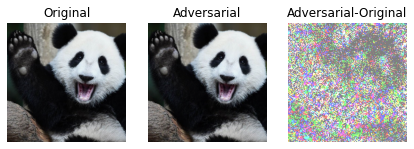

In [70]:
if result:
  adv = adv.transpose(1, 2, 0)
  adv = (adv * std) + mean
  adv = adv * 256.0
  adv = np.clip(adv, 0, 255).astype(np.uint8)
  show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)

### Inception

In [71]:
# Define what device we are using
logging.info("CUDA Available: {}".format(torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# bgr -> rgb   
orig = cv2.imread(image_path)[..., ::-1]

orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std

 
#[224,224,3]->[3,224,224]
img = img.transpose(2, 0, 1)

img = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0)).cpu().numpy()


# Initialize the network

model = models.inception_v3(pretrained=True).to(device).eval()

#print(model)


for param in model.parameters():
    param.requires_grad = False

# advbox demo
m = PytorchModel(
    model, None,(-3, 3),
    channel_axis=1)
attack = FGSMT(m)

#epsilons
attack_config = {"epsilons": 0.001, "epsilon_steps": 1, "steps": 100}

inputs=img
labels = None

print(inputs.shape)

adversary = Adversary(inputs, labels)

tlabel = 538
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)


if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]

else:
    result = False
    print('attack failed')


print("fgsm attack done")

<ipython-input-71-73609d468a97>[line:2] INFO CUDA Available: False
pytorch.py[line:53] INFO Finish PytorchModel init
base.py[line:75] INFO adversary:
         original_label: 388
         target_label: 538
         is_targeted_attack: True


cpu
(1, 3, 224, 224)


gradient_method.py[line:74] INFO epsilons=0.001,epsilons_max=0.5,steps=100,epsilon_steps=1
gradient_method.py[line:121] INFO step=1, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=17.366607666015625
gradient_method.py[line:121] INFO step=2, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=16.524484634399414
gradient_method.py[line:121] INFO step=3, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=15.717870712280273
gradient_method.py[line:121] INFO step=4, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=14.84203815460205
gradient_method.py[line:121] INFO step=5, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=13.814815521240234
gradient_method.py[line:121] INFO step=6, epsilon = 0.00100, pre_label = 388, adv_label=850 logits=12.681102752685547
gradient_method.py[line:121] INFO step=7, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=12.56173324584961
gradient_method.py[line:121] INFO step=8, epsilon = 0.00100, pre_label = 388, adv_lab

attack success, adversarial_label=538
fgsm attack done


l0=95106 l2=60041.786524053394


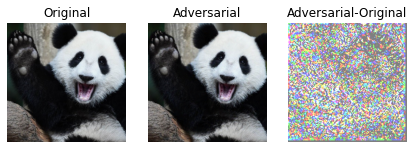

In [72]:
if result:
  adv = adv.transpose(1, 2, 0)
  adv = (adv * std) + mean
  adv = adv * 256.0
  adv = np.clip(adv, 0, 255).astype(np.uint8)
  show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)

### Googlenet

In [73]:
# Define what device we are using
logging.info("CUDA Available: {}".format(torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# bgr -> rgb   
orig = cv2.imread(image_path)[..., ::-1]

orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std

 
#[224,224,3]->[3,224,224]
img = img.transpose(2, 0, 1)

img = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0)).cpu().numpy()


# Initialize the network

model = models.googlenet(pretrained=True).to(device).eval()

#print(model)


for param in model.parameters():
    param.requires_grad = False

# advbox demo
m = PytorchModel(
    model, None,(-3, 3),
    channel_axis=1)
attack = FGSMT(m)

#epsilons
attack_config = {"epsilons": 0.001, "epsilon_steps": 1, "steps": 100}

inputs=img
labels = None

print(inputs.shape)

adversary = Adversary(inputs, labels)

tlabel = 538
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)


if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]

else:
    result = False
    print('attack failed')


print("fgsm attack done")

<ipython-input-73-1c7a219d9c54>[line:2] INFO CUDA Available: False
pytorch.py[line:53] INFO Finish PytorchModel init
base.py[line:75] INFO adversary:
         original_label: 388
         target_label: 538
         is_targeted_attack: True
gradient_method.py[line:74] INFO epsilons=0.001,epsilons_max=0.5,steps=100,epsilon_steps=1


cpu
(1, 3, 224, 224)


gradient_method.py[line:121] INFO step=1, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=8.263147354125977
gradient_method.py[line:121] INFO step=2, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=7.621665000915527
gradient_method.py[line:121] INFO step=3, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=7.1043572425842285
gradient_method.py[line:121] INFO step=4, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=6.690306186676025
gradient_method.py[line:121] INFO step=5, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=6.374022960662842
gradient_method.py[line:121] INFO step=6, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=6.18680477142334
gradient_method.py[line:121] INFO step=7, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=5.9166483879089355
gradient_method.py[line:121] INFO step=8, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=5.832662105560303
gradient_method.py[line:121] INFO step=9, epsilon = 0.00100, pr

attack success, adversarial_label=538
fgsm attack done


l0=94331 l2=60785.90959260213


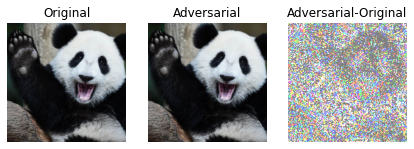

In [74]:
if result:
  adv = adv.transpose(1, 2, 0)
  adv = (adv * std) + mean
  adv = adv * 256.0
  adv = np.clip(adv, 0, 255).astype(np.uint8)
  show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)

### Densenet

In [75]:
# Define what device we are using
logging.info("CUDA Available: {}".format(torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# bgr -> rgb   
orig = cv2.imread(image_path)[..., ::-1]

orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std

 
#[224,224,3]->[3,224,224]
img = img.transpose(2, 0, 1)

img = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0)).cpu().numpy()


# Initialize the network

model = models.densenet121(pretrained=True).to(device).eval()

#print(model)


for param in model.parameters():
    param.requires_grad = False

# advbox demo
m = PytorchModel(
    model, None,(-3, 3),
    channel_axis=1)
attack = FGSMT(m)

#epsilons
attack_config = {"epsilons": 0.001, "epsilon_steps": 1, "steps": 100}

inputs=img
labels = None

print(inputs.shape)

adversary = Adversary(inputs, labels)

tlabel = 538
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)


if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]

else:
    result = False
    print('attack failed')


print("fgsm attack done")

<ipython-input-75-f979450c0c94>[line:2] INFO CUDA Available: False
pytorch.py[line:53] INFO Finish PytorchModel init
base.py[line:75] INFO adversary:
         original_label: 388
         target_label: 538
         is_targeted_attack: True
gradient_method.py[line:74] INFO epsilons=0.001,epsilons_max=0.5,steps=100,epsilon_steps=1


cpu
(1, 3, 224, 224)


gradient_method.py[line:121] INFO step=1, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=12.732601165771484
gradient_method.py[line:121] INFO step=2, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=10.902490615844727
gradient_method.py[line:121] INFO step=3, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=9.45980453491211
gradient_method.py[line:121] INFO step=4, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=8.36190128326416
gradient_method.py[line:121] INFO step=5, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=7.572446823120117
gradient_method.py[line:121] INFO step=6, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=7.19917631149292
gradient_method.py[line:121] INFO step=7, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=6.866600513458252
gradient_method.py[line:121] INFO step=8, epsilon = 0.00100, pre_label = 388, adv_label=388 logits=6.651029586791992
gradient_method.py[line:121] INFO step=9, epsilon = 0.00100, pre_

attack success, adversarial_label=538
fgsm attack done


l0=79192 l2=57177.53698787663


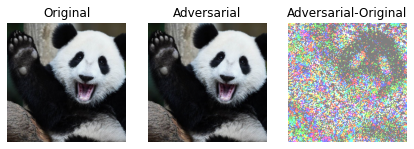

In [76]:
if result:
  adv = adv.transpose(1, 2, 0)
  adv = (adv * std) + mean
  adv = adv * 256.0
  adv = np.clip(adv, 0, 255).astype(np.uint8)
  show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)

### EfficientNet

In [77]:
!pip install efficientnet_pytorch

In [78]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b2')

In [79]:
# Define what device we are using
logging.info("CUDA Available: {}".format(torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# bgr -> rgb   
orig = cv2.imread(image_path)[..., ::-1]

orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std

 
#[224,224,3]->[3,224,224]
img = img.transpose(2, 0, 1)

img = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0)).cpu().numpy()


# Initialize the network

model = EfficientNet.from_name('efficientnet-b2').to(device).eval()

#print(model)


for param in model.parameters():
    param.requires_grad = False

# advbox demo
m = PytorchModel(
    model, None,(-3, 3),
    channel_axis=1)
attack = FGSMT(m)

#epsilons
attack_config = {"epsilons": 0.001, "epsilon_steps": 1, "steps": 100}

inputs=img
labels = None

print(inputs.shape)

adversary = Adversary(inputs, labels)

tlabel = 538
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)


if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]

else:
    result = False
    print('attack failed')


print("fgsm attack done")

<ipython-input-79-ded62c0f1469>[line:2] INFO CUDA Available: False
pytorch.py[line:53] INFO Finish PytorchModel init
base.py[line:75] INFO adversary:
         original_label: 550
         target_label: 538
         is_targeted_attack: True
gradient_method.py[line:74] INFO epsilons=0.001,epsilons_max=0.5,steps=100,epsilon_steps=1


cpu
(1, 3, 224, 224)


gradient_method.py[line:121] INFO step=1, epsilon = 0.00100, pre_label = 550, adv_label=550 logits=0.02658224292099476
gradient_method.py[line:121] INFO step=2, epsilon = 0.00100, pre_label = 550, adv_label=550 logits=0.02658224292099476
gradient_method.py[line:121] INFO step=3, epsilon = 0.00100, pre_label = 550, adv_label=550 logits=0.02658224292099476
gradient_method.py[line:121] INFO step=4, epsilon = 0.00100, pre_label = 550, adv_label=550 logits=0.02658224292099476
gradient_method.py[line:121] INFO step=5, epsilon = 0.00100, pre_label = 550, adv_label=550 logits=0.02658224292099476
gradient_method.py[line:121] INFO step=6, epsilon = 0.00100, pre_label = 550, adv_label=550 logits=0.02658224292099476
gradient_method.py[line:121] INFO step=7, epsilon = 0.00100, pre_label = 550, adv_label=550 logits=0.02658224292099476
gradient_method.py[line:121] INFO step=8, epsilon = 0.00100, pre_label = 550, adv_label=550 logits=0.02658224292099476
gradient_method.py[line:121] INFO step=9, epsilo

attack failed
fgsm attack done


In [80]:
if result:
  adv = adv.transpose(1, 2, 0)
  adv = (adv * std) + mean
  adv = adv * 256.0
  adv = np.clip(adv, 0, 255).astype(np.uint8)
  show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)